In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HAR/HAR/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset('D:/Son/3-2/deeplearning/report/dataset/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
#BiLSTM

## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [5]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(100), input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              88000     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 108,706
Trainable params: 108,706
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 26s 244ms/step - loss: 1.1210 - accuracy: 0.5254 - val_loss: 1.1102 - val_accuracy: 0.5194
Epoch 2/10
92/92 [==============================] - 23s 250ms/step - loss: 0.7504 - accuracy: 0.6973 - val_loss: 0.6981 - val_accuracy: 0.7777
Epoch 3/10
92/92 [==============================] - 23s 251ms/step - loss: 0.6296 - accuracy: 0.7540 - val_loss: 0.6378 - val_accuracy: 0.8124
Epoch 4/10
92/92 [==============================] - 23s 251ms/step - loss: 0.4294 - accuracy: 0.8371 - val_loss: 0.5331 - val_accuracy: 0.8382
Epoch 5/10
92/92 [==============================] - 23s 252ms/step - loss: 0.3232 - accuracy: 0.8839 - val_loss: 0.5248 - val_accuracy: 0.8321
Epoch 6/10
92/92 [==============================] - 23s 249ms/step - loss: 0.2390 - accuracy: 0.9135 - val_loss: 0.3839 - val_accuracy: 0.9021
Epoch 7/10
92/92 [==============================] - 23s 248ms/step - loss: 0.1846 - accuracy: 0.9381 - val_loss: 0.5021 - val_accuracy: 0.8878

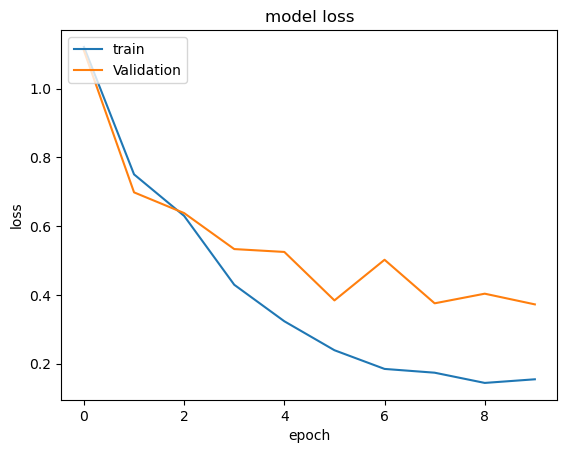

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [9]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the BiLSTM model 0.8954869508743286
93/93 [==============================] - 3s 28ms/step


In [10]:
predictions

array([[1.2550086e-03, 1.4970027e-04, 8.1746439e-05, 1.3080553e-02,
        9.8543268e-01, 3.4465981e-07],
       [1.1895921e-03, 1.7438518e-04, 9.3284878e-05, 1.7647082e-02,
        9.8089522e-01, 5.2607425e-07],
       [1.2334406e-03, 1.7957129e-04, 9.8107696e-05, 1.9135028e-02,
        9.7935325e-01, 5.8965441e-07],
       ...,
       [1.0375353e-03, 9.9080241e-01, 8.1436615e-03, 8.4461368e-07,
        1.2751287e-05, 2.7835586e-06],
       [2.8829419e-03, 9.8954237e-01, 7.4513322e-03, 7.1767563e-06,
        1.0275667e-04, 1.3422635e-05],
       [2.3678800e-03, 9.9474382e-01, 2.6199697e-03, 1.8928864e-05,
        2.2266449e-04, 2.6676111e-05]], dtype=float32)

In [11]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[442  15  39   0   0   0]
 [ 15 429  27   0   0   0]
 [  6   7 407   0   0   0]
 [  0  24   0 406  61   0]
 [  4   0   0  80 448   0]
 [  0  30   0   0   0 507]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.95      0.89      0.92       496
           2       0.85      0.91      0.88       471
           3       0.86      0.97      0.91       420
           4       0.84      0.83      0.83       491
           5       0.88      0.84      0.86       532
           6       1.00      0.94      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



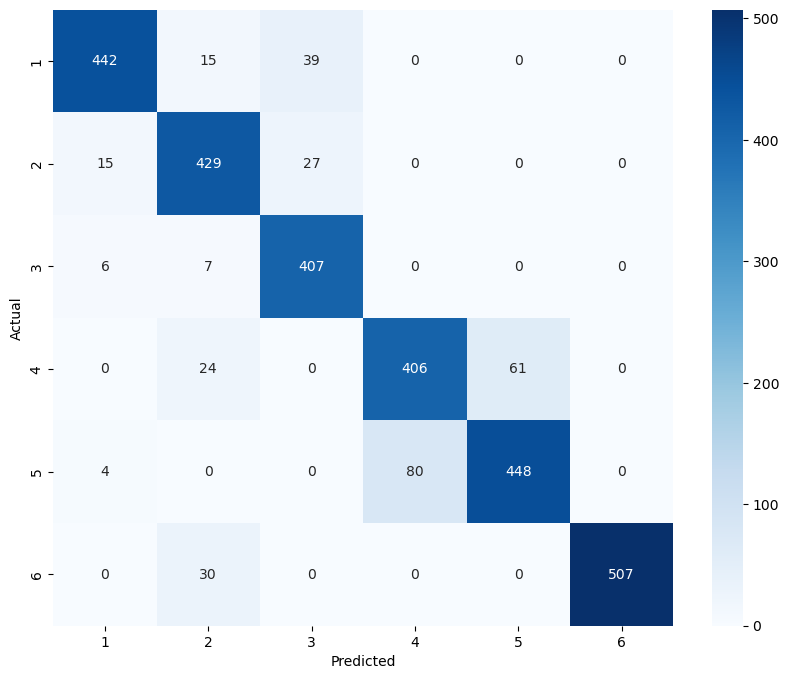

In [12]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [13]:
#GRU
from keras.layers import GRU

model_GRU = Sequential()
model_GRU.add(GRU(100, input_shape=(n_timesteps,n_features)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(100, activation='relu'))
model_GRU.add(Dense(n_outputs, activation='softmax'))

model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               33300     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 44,006
Trainable params: 44,006
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# fit network
train_epochs = 10
history_GRU = model_GRU.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 12s 105ms/step - loss: 1.2719 - accuracy: 0.4647 - val_loss: 1.1540 - val_accuracy: 0.5330
Epoch 2/10
92/92 [==============================] - 9s 95ms/step - loss: 0.9914 - accuracy: 0.5756 - val_loss: 1.0353 - val_accuracy: 0.5860
Epoch 3/10
92/92 [==============================] - 9s 95ms/step - loss: 0.8015 - accuracy: 0.6581 - val_loss: 0.6702 - val_accuracy: 0.7294
Epoch 4/10
92/92 [==============================] - 9s 99ms/step - loss: 0.5196 - accuracy: 0.7783 - val_loss: 0.3994 - val_accuracy: 0.8477
Epoch 5/10
92/92 [==============================] - 9s 96ms/step - loss: 0.3700 - accuracy: 0.8553 - val_loss: 0.3082 - val_accuracy: 0.8919
Epoch 6/10
92/92 [==============================] - 9s 100ms/step - loss: 0.2243 - accuracy: 0.9189 - val_loss: 0.2823 - val_accuracy: 0.9116
Epoch 7/10
92/92 [==============================] - 9s 97ms/step - loss: 0.2037 - accuracy: 0.9255 - val_loss: 0.3137 - val_accuracy: 0.9191
Epoch 8/10

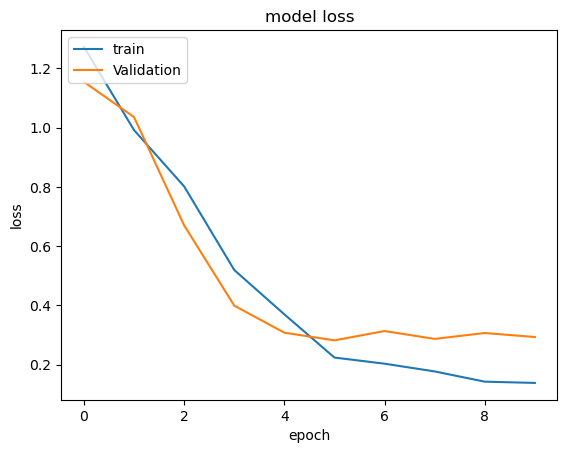

In [16]:
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [17]:
# evaluate model
test_loss, test_accuracy = model_GRU.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
# Get the predictions for the test set
predictions = model_GRU.predict(testX)

Accuracy of the GRU model 0.8683406710624695
93/93 [==============================] - 2s 19ms/step


In [18]:
predictions

array([[1.08867027e-02, 1.73023407e-04, 1.26966013e-04, 8.40448425e-04,
        9.87972617e-01, 2.08726249e-07],
       [2.57672672e-03, 1.14335060e-04, 1.14444476e-04, 2.33948487e-03,
        9.94854450e-01, 4.35363035e-07],
       [2.25866470e-03, 1.10312933e-04, 1.15217765e-04, 2.61320942e-03,
        9.94902134e-01, 4.56737695e-07],
       ...,
       [1.42296532e-03, 9.98576522e-01, 1.19324596e-07, 2.05003126e-09,
        2.29657644e-07, 8.07969087e-08],
       [9.23447602e-04, 9.99076009e-01, 6.89793040e-08, 2.06973128e-09,
        3.09683202e-07, 1.12074702e-07],
       [1.12844142e-03, 9.98870790e-01, 5.74666679e-08, 3.07111936e-09,
        5.57747512e-07, 1.53107138e-07]], dtype=float32)

In [19]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[467  28   1   0   0   0]
 [ 99 369   3   0   0   0]
 [ 21   3 396   0   0   0]
 [ 22   2   1 394  72   0]
 [  5   0   0 104 423   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.76      0.94      0.84       496
           2       0.86      0.78      0.82       471
           3       0.99      0.94      0.96       420
           4       0.79      0.80      0.80       491
           5       0.85      0.80      0.82       532
           6       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.88      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



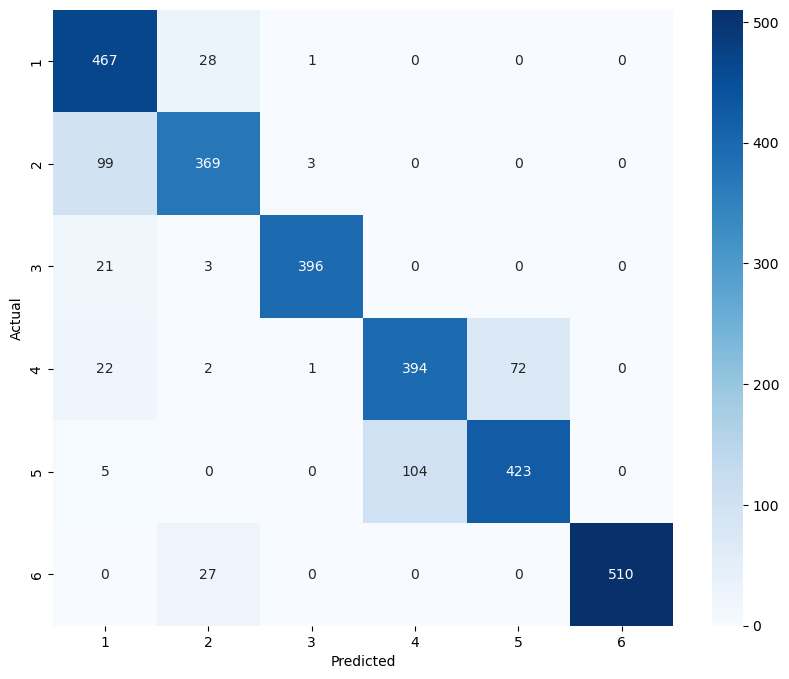

In [20]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [21]:
#BiGRU

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model_BiGRU = Sequential()
model_BiGRU.add(Bidirectional(GRU(100), input_shape=(n_timesteps,n_features)))
model_BiGRU.add(Dropout(0.5))
model_BiGRU.add(Dense(100, activation='relu'))
model_BiGRU.add(Dense(n_outputs, activation='softmax'))

model_BiGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 200)              66600     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 87,306
Trainable params: 87,306
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# fit network
train_epochs = 10
history_BiGRU = model_BiGRU.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 21s 189ms/step - loss: 1.1903 - accuracy: 0.4991 - val_loss: 1.0820 - val_accuracy: 0.6193
Epoch 2/10
92/92 [==============================] - 17s 184ms/step - loss: 0.8867 - accuracy: 0.6366 - val_loss: 0.7526 - val_accuracy: 0.6839
Epoch 3/10
92/92 [==============================] - 17s 181ms/step - loss: 0.5161 - accuracy: 0.8062 - val_loss: 0.4964 - val_accuracy: 0.8511
Epoch 4/10
92/92 [==============================] - 17s 182ms/step - loss: 0.3071 - accuracy: 0.8876 - val_loss: 0.4237 - val_accuracy: 0.8355
Epoch 5/10
92/92 [==============================] - 17s 180ms/step - loss: 0.2199 - accuracy: 0.9189 - val_loss: 0.3685 - val_accuracy: 0.8783
Epoch 6/10
92/92 [==============================] - 16s 176ms/step - loss: 0.1782 - accuracy: 0.9325 - val_loss: 0.3076 - val_accuracy: 0.8953
Epoch 7/10
92/92 [==============================] - 16s 173ms/step - loss: 0.1609 - accuracy: 0.9401 - val_loss: 0.2560 - val_accuracy: 0.9041

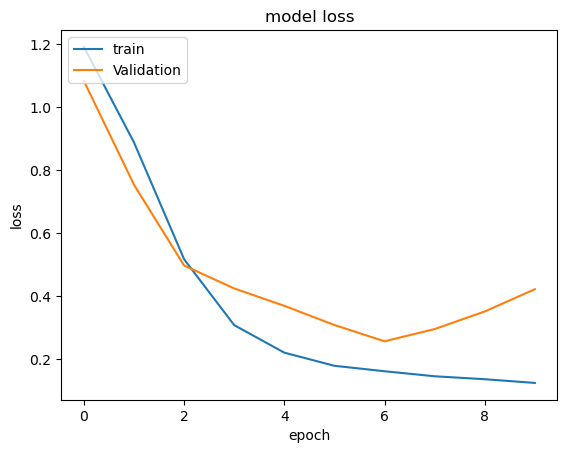

In [24]:
plt.plot(history_BiGRU.history['loss'])
plt.plot(history_BiGRU.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [25]:
# evaluate model
test_loss, test_accuracy = model_BiGRU.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiGRU model", test_accuracy)
# Get the predictions for the test set
predictions = model_BiGRU.predict(testX)

Accuracy of the BiGRU model 0.8815745115280151
93/93 [==============================] - 3s 21ms/step


In [26]:
predictions

array([[7.12560199e-04, 4.25422550e-05, 4.15987568e-04, 4.32279427e-03,
        9.94505942e-01, 9.94257690e-08],
       [2.68225325e-04, 8.76952708e-06, 6.92053218e-05, 3.78488074e-03,
        9.95868921e-01, 1.39253284e-08],
       [2.95377657e-04, 8.52020366e-06, 7.44465142e-05, 4.30127280e-03,
        9.95320380e-01, 1.38424454e-08],
       ...,
       [2.67495238e-03, 9.97307301e-01, 1.49709185e-05, 7.78901721e-10,
        2.49710274e-06, 2.14840071e-07],
       [3.27493035e-04, 9.99669313e-01, 2.32159096e-06, 5.80735182e-10,
        1.13819922e-07, 7.41651547e-07],
       [1.13939564e-03, 9.98851538e-01, 6.84504948e-06, 1.91114680e-09,
        2.08914074e-07, 2.01757939e-06]], dtype=float32)

In [27]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[470  21   4   0   1   0]
 [ 47 387  36   0   1   0]
 [  1   1 416   0   2   0]
 [  1   2   1 380 107   0]
 [  3   0   1  82 446   0]
 [  0  38   0   0   0 499]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.90      0.95      0.92       496
           2       0.86      0.82      0.84       471
           3       0.91      0.99      0.95       420
           4       0.82      0.77      0.80       491
           5       0.80      0.84      0.82       532
           6       1.00      0.93      0.96       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



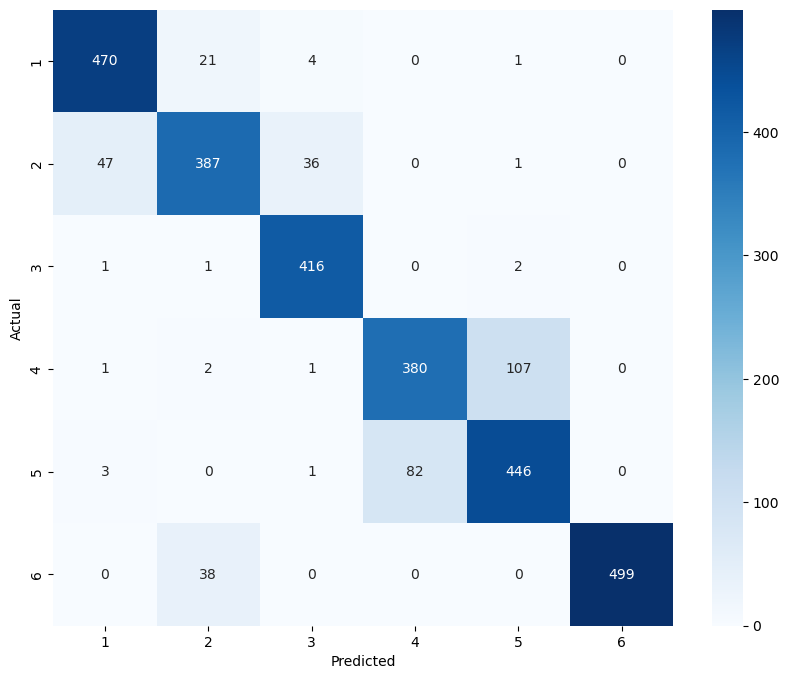

In [28]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)